In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils

from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [2]:
ls ./frames

2018-04-21-20-41-25/


In [3]:
# Set up some parmaeters for data loading

#Plug in your training dir

#Other user
#TRAIN_DIR = './frames/something..etc/'

#Andy
TRAIN_DIR = './frames/2018-04-21-20-41-25/'

#Conor
#TRAIN_DIR = './frames/something..etc/'

sample_rate = 0.1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 3848
Processed 1000 of 3848
Processed 2000 of 3848
Processed 3000 of 3848
Train shape: (3848, 1, 64, 64)


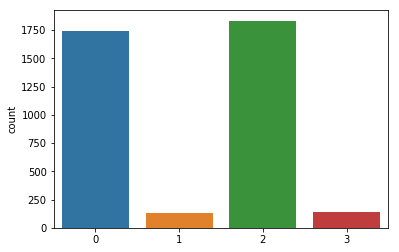

In [4]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

0


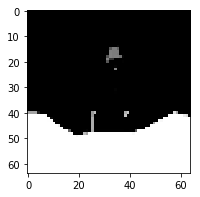

0


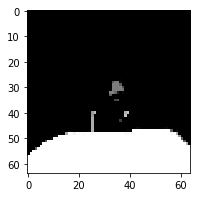

0


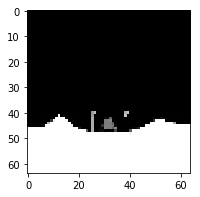

2


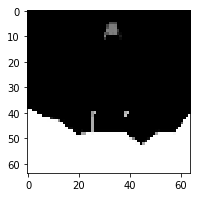

2


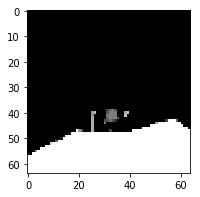

In [5]:
#show some screens
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

In [6]:
#train test split
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

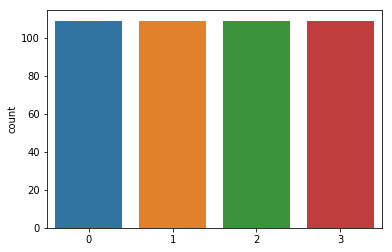

In [7]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

In [8]:
#Build Keras Models

#build Keras model
def build_fn(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])
    return model

#wrap Keras model for sklearn API
#model = KerasClassifier(build_fn=func_name, **func_kwargs, verbose=1)
model = KerasClassifier(build_fn=build_fn, dropout_rate=0.1, verbose=1)

In [9]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

#params for grid search
param_grid = {
    
    #training params
    "epochs":list(range(10,11,5)),   
    "batch_size":[2**i for i in range(7,8)], #powers of 2
    "validation_split":[0.25,],
    "shuffle":[True],
    
    #model structural hyperparams
    #these depend on args for build_fn
    "dropout_rate":[0.1],
    #"optimizer":['SGD', 'RMSprop', 'Adagrad', 'Adam'],
    #"activation":['relu', 'softmax'],
    #Learning rate
    #momentum etc.
    #init_mode #initial weightings
}

#create gridsearch object
grid = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   n_jobs=1,
                   #verbose=1,
                   refit=True,
                   return_train_score=True)

#run gridsearch
gs_clfs = grid.fit(train_rus, 
                   train_labels_rus_wide,
                  )

Train on 217 samples, validate on 73 samples
Epoch 1/10
217/217 [==============================] - 5s 25ms/step - loss: 1.5604 - acc: 0.2396 - val_loss: 1.3876 - val_acc: 0.2192
Epoch 2/10
217/217 [==============================] - 5s 23ms/step - loss: 1.3874 - acc: 0.3134 - val_loss: 1.4027 - val_acc: 0.2192
Epoch 3/10
217/217 [==============================] - 5s 23ms/step - loss: 1.3893 - acc: 0.2627 - val_loss: 1.3872 - val_acc: 0.2740
Epoch 4/10
217/217 [==============================] - 5s 23ms/step - loss: 1.3465 - acc: 0.4147 - val_loss: 1.3908 - val_acc: 0.2466
Epoch 5/10
217/217 [==============================] - 5s 23ms/step - loss: 1.3446 - acc: 0.3594 - val_loss: 1.4044 - val_acc: 0.2329
Epoch 6/10
217/217 [==============================] - 5s 22ms/step - loss: 1.3429 - acc: 0.3687 - val_loss: 1.4120 - val_acc: 0.2329
Epoch 7/10
217/217 [==============================] - 5s 23ms/step - loss: 1.3367 - acc: 0.3963 - val_loss: 1.3978 - val_acc: 0.2740
Epoch 8/10
217/217 [====

In [10]:
#some printables re:gridsearch
pd.DataFrame(gs_clfs.cv_results_)
gs_clfs.best_estimator_.get_params()
gs_clfs.best_params_


{'batch_size': 128,
 'dropout_rate': 0.1,
 'epochs': 10,
 'validation_split': 0.25}

In [11]:
#rebuild model without sklearn wrapper (its easier to work with).
dropout_rate = gs_clfs.best_params_['dropout_rate']
params = {k:v for k,v in gs_clfs.best_params_.items() if k!='dropout_rate'}
model = build_fn(dropout_rate=dropout_rate)
history = gs_clfs.best_estimator_.fit(train_rus, train_labels_rus_wide, 
                                      **params,
                                      verbose=1, )


Train on 327 samples, validate on 109 samples
Epoch 1/10
327/327 [==============================] - 8s 25ms/step - loss: 1.4525 - acc: 0.2661 - val_loss: 1.4091 - val_acc: 0.2661
Epoch 2/10
327/327 [==============================] - 7s 22ms/step - loss: 1.4234 - acc: 0.2630 - val_loss: 1.4329 - val_acc: 0.2110
Epoch 3/10
327/327 [==============================] - 8s 23ms/step - loss: 1.3328 - acc: 0.3364 - val_loss: 1.3759 - val_acc: 0.2477
Epoch 4/10
327/327 [==============================] - 8s 24ms/step - loss: 1.3216 - acc: 0.3486 - val_loss: 1.3549 - val_acc: 0.3578
Epoch 5/10
327/327 [==============================] - 7s 22ms/step - loss: 1.2647 - acc: 0.4679 - val_loss: 1.3893 - val_acc: 0.2936
Epoch 6/10
327/327 [==============================] - 7s 23ms/step - loss: 1.2361 - acc: 0.4098 - val_loss: 1.3650 - val_acc: 0.2936
Epoch 7/10
327/327 [==============================] - 7s 22ms/step - loss: 1.1916 - acc: 0.5352 - val_loss: 1.3254 - val_acc: 0.3578
Epoch 8/10
327/327 [===

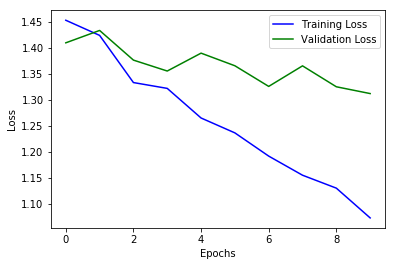

In [12]:
#plot loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,params['epochs'])[0::2])
plt.legend()
plt.show()

In [13]:
#Evaluate with Test dataset

print("****** Test Data ********")
# Make a set of predictions for the validation data
#pred = gs_clfs.best_estimator_.predict_classes(test) for keras style
pred = gs_clfs.best_estimator_.predict(test)  #for estimator objects

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

#Accuracy
print(metrics.accuracy_score(test_labels, pred))

****** Test Data ********
770/770 [==============================] - 9s 12ms/step
             precision    recall  f1-score   support

          0       0.68      0.43      0.53       351
          1       0.07      0.35      0.12        26
          2       0.62      0.45      0.52       372
          3       0.06      0.43      0.10        21

avg / total       0.61      0.44      0.50       770

Confusion Matrix
[[151  47  95  58]
 [  4   9   7   6]
 [ 64  60 169  79]
 [  2   7   3   9]]
0.438961038961


In [14]:
#save a model
filepath = "player.mod"
model.save(filepath)

#load a model
model = keras.models.load_model("player.mod")